In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('rise', {
              'width': 1000,
              'height': 800,
              'scroll': True,
              "theme": "blood",
              "autolaunch": True
})

NameError: name 'true' is not defined

### Can personality traits and demographics predict drug use? 
*Using supervised learning to classify drug consuption behavior*

### By Micaela McCall

One of the first things that fascinated me about machine learning is the ability to predict the behavior of individuals.

### Dataset

The data set I chose was the drug consumption dataset from UCI, which contains demographic info as well as scores from personality inventories. 

### Goals
In this project, I explored the ability of three supervised learning algorithms to predict whether an individual has used a specific drug. I explored and visualized parameter selection for each model, as well as how metrics can help us select the best model for a problem.

### Outline 
**1. Import data**
2. Prepare data for machine learning
3. Selecting target variable for classification
4. Explore data
5. Training classification models
6. Selecting a model
7. Generating predictions on test data

In [28]:
from urllib.request import urlretrieve
urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data", 
            "drug_consumption.data");

In [29]:
import pandas as pd
import os

def load_drug_data():
    """A function to load the data into the environemnt"""
    
    # Column headers:
    header_list=['ID','Age','Gender','Education','Country', 'Ethnicity', 'Nscore','Escore','Oscore','Ascore','Cscore','ImpulsiveScore','SS','Alcohol','Amphet','Amyl','Benzos','Caff','Cannabis','Choc','Coke','Crack','Ecstacy','Heroin','Ketamine','LegalH','LSD','Meth','Mushroom','Nicotine','Semeron','VSA']
    
    # Read in data 
    drug_df = pd.read_csv("drug_consumption.data", header=None, names=header_list)
    
    return drug_df

# Import and load data
drug_df = load_drug_data()
drug_df.shape

(1885, 32)

### Outline 
1. Import data

**2. Prepare data for machine learning**
3. Selecting target variable for classification
4. Explore data
5. Training classification models
6. Selecting a model
7. Generating predictions on test data

In [30]:
drug_df.head()

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,...,Ecstacy,Heroin,Ketamine,LegalH,LSD,Meth,Mushroom,Nicotine,Semeron,VSA
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


Note:

1. I want to do binary classification, so need to change the drug columns to 0 and 1.
2. Gender, Ethnicity, Education, and Country are encoded as real numbers. However, there is no ordering betwen the levels of these features, so they should be treated as discrete. 
3. The personality scores are scaled to a mean of 0 and standard deviation of 1 already, so these features don't need to be processed. 

In [31]:
def binarize_categorical_variable(df, column, yescat):
    """ 
    Fuction to turns a categorical variable in a DataFrame into a 0 or 1 response

    Arguments: 
    df = pandas DataFrame, 
    column = name of variable column as string
    yes = quoted *and bracketed* list of category names that you wish to turn to 1

    Returns: the original pandas df with new binarized variable"""

    # Change column to category dtype so that we can access it with .categories method
    df.loc[:,column]=df.loc[:,column].astype('category')
    
    # Create list of categories in column
    category_list = [] 
    
    for cat in df[column].cat.categories:
        category_list.append(cat)

    # Create dictionary with 1 for yes categories and 0 for no categories
    repl_dict = {}

    for cat in category_list:
        for yes in yescat:
            if cat == yes:
                repl_dict[cat] = 1   
        if repl_dict.get(cat) == None:
            repl_dict[cat] = 0

    # Replace original column in DataFrame
    df.loc[:,column] = df.loc[:,column].replace(repl_dict)

    return df

In [32]:
def new_categories(df, column, newcat):
    """ 
    Function to replace categories in a variables with new category names
    
    Arguments:
    df =  a pandas DataFrame
    column = name of variable column as string
    newcat = a list of strings that name the new category names
    
    Output: a pandas DataFrame with new column names"""

    # Change column to category dtype so that we can access it with .categories method
    df.loc[:,column]=df.loc[:,column].astype('category')

    # Create list of categories in this variable
    category_list = []

    for cat in df[column].cat.categories:
        category_list.append(cat)

    # Create a dictionary of new names for each old category name
    repl_dict = {}

    for i, cat in enumerate(category_list):
        repl_dict[cat] = newcat[i]

    df.loc[:,column] = df.loc[:,column].replace(repl_dict)

    return df

### After applying the functions to the dataframe...

In [33]:
def cleanup_drug_df(df):
    """ A function to clean up the drug dataframe 
    
    Argument: Pandas DataFame
    
    Output: Cleaned up data as pandas DataFrame"""

    # Binarize the drug columns

    drug_df_clean = df

    for column in drug_df.columns[13:]:
        drug_df_clean = binarize_categorical_variable(drug_df_clean, column, yescat=['CL1','Cl2','CL3','CL4','CL5','CL6'])


    # Responses from individuals who said they had done an imaginary drug probably arent repliable,
    # so they are removed

    drug_df_clean = drug_df_clean[drug_df_clean.Semeron==0]



    new_categories_list = [
        ['18-24','25-34','35-44','45-54','55-64','65-100'],
        ['Female','Male'],
        ['Left school before age 16', 'Left school at age 16', 'Left school at age 17', 'Left school at age 18', 'Some college or university','Professional diploma/certificate', 'University degree', 'Masters degree', 'Doctorate degree'],
        ['USA','New Zealand','Other', 'Australia', 'Republic of Ireland','Canada', 'UK'],
        ['Black', 'Asian','White','Mixed Black/White','Other','Mixed White/Asian','Mixed Black/Asian']]

    columns_to_replace = ['Age', 'Gender', 'Education', 'Country', 'Ethnicity']

    for i, column in enumerate(columns_to_replace):
        new_categories(drug_df_clean, column, new_categories_list[i])
    
    return drug_df_clean


# Cleanup drug DataFrame
drug_df_clean=cleanup_drug_df(drug_df)

/Users/micamccall/anaconda3/envs/py2019/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [34]:
drug_df_clean.head()

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,...,Ecstacy,Heroin,Ketamine,LegalH,LSD,Meth,Mushroom,Nicotine,Semeron,VSA
0,1,35-44,Male,Professional diploma/certificate,UK,Mixed White/Asian,0.31287,-0.57545,-0.58331,-0.91699,...,0,0,0,0,0,0,0,0,0,0
1,2,25-34,Female,Doctorate degree,UK,White,-0.67825,1.93886,1.43533,0.76096,...,1,0,0,0,0,1,0,1,0,0
2,3,35-44,Female,Professional diploma/certificate,UK,White,-0.46725,0.80523,-0.84732,-1.62090,...,0,0,0,0,0,0,1,0,0,0
3,4,18-24,Male,Masters degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,...,0,0,0,0,0,0,0,0,0,0
4,5,35-44,Male,Doctorate degree,UK,White,0.73545,-1.63340,-0.45174,-0.30172,...,1,0,0,1,0,0,0,0,0,0


### Outline 
1. Import data
2. Prepare data for machine learning

**3. Selecting target variable for classification**
4. Explore data
5. Training classification models
6. Selecting a model
7. Generating predictions on test data

In [35]:
drug_df_clean.loc[:,"Cannabis"].value_counts()

1    1201
0     679
Name: Cannabis, dtype: int64

### Dealing with age

I decided to create two new columns 'Upper_Age' and 'Lower_Age', which replace the Age column because that preserves the most information

In [36]:
def make_single_drug_df(df_full, drug):

    """
    A function to select a single drug as the target variable, process age variable, and isolate features dataset

    Arguments: 
    df_full = the full drug pandas Dataframe
    drug = the name of the drug column of interest as a string

    Returns:
    a tuple that is the single drug pandas dataframe and the features dataframe    
    """
    cols = [
        'ID','Age', 'Gender', 'Education', 'Country', 
        'Ethnicity', 'Nscore', 'Escore', 'Oscore', 
        'Ascore', 'Cscore', 'ImpulsiveScore','SS', drug]

    df = df_full.loc[:,cols]

    # create a new feature for the lower bound of the age and the upper bound the age.
    df['Lower_Age'], df['Upper_Age'] = zip(*df['Age'].map(lambda x: x.split('-')))

    # Convert lower and upper age to floats
    df.Lower_Age=df.Lower_Age.astype('float')
    df.Upper_Age=df.Upper_Age.astype('float')

    # Make dataframe of features
    features=df.drop(['ID','Age', drug], axis = 1)

    returns = (df, features)

    return returns

drug = 'Cannabis'
df, features = make_single_drug_df(df_full=drug_df_clean, drug= drug)   

### Outline 
1. Import data
2. Prepare data for machine learning
3. Selecting target variable for classification

**4. Explore data**
5. Training classification models
6. Selecting a model
7. Generating predictions on test data

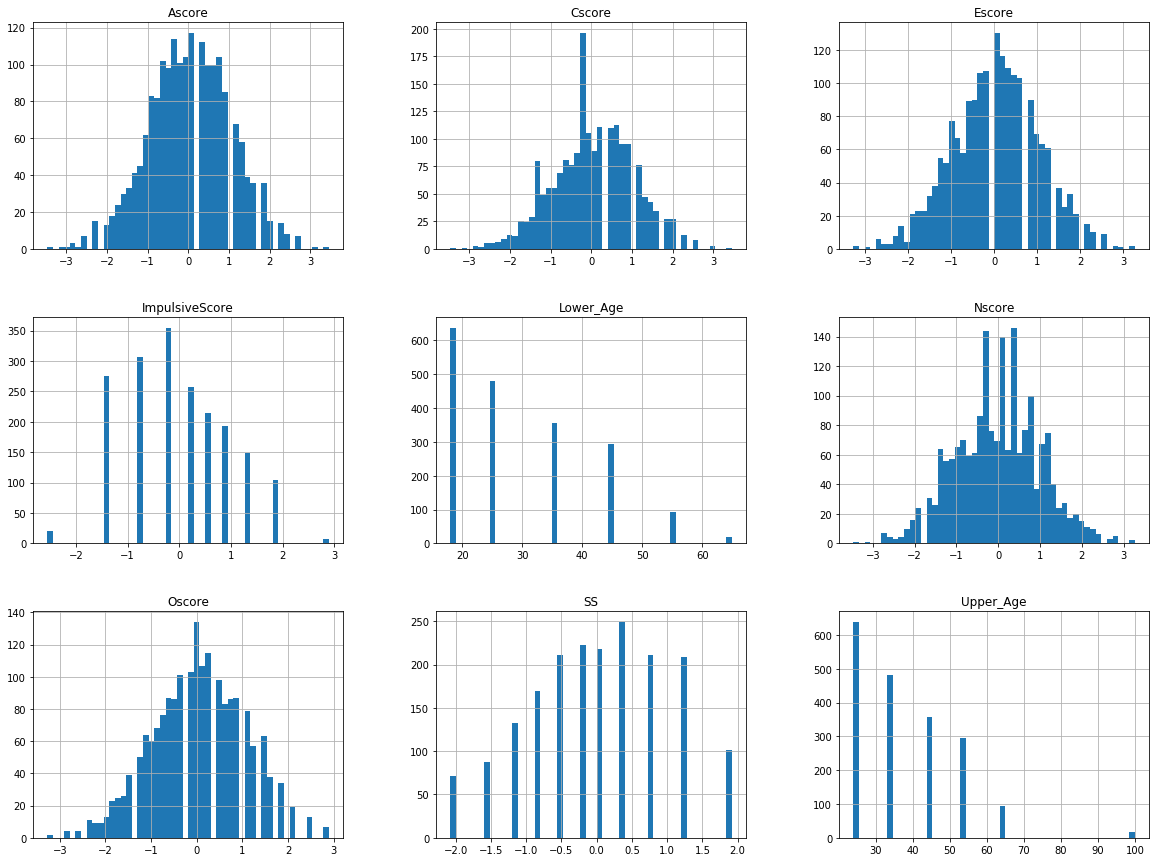

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Look at the distribution of the numerical variables
df.drop(columns=['ID', drug]).hist(bins=50, figsize=(20,15));

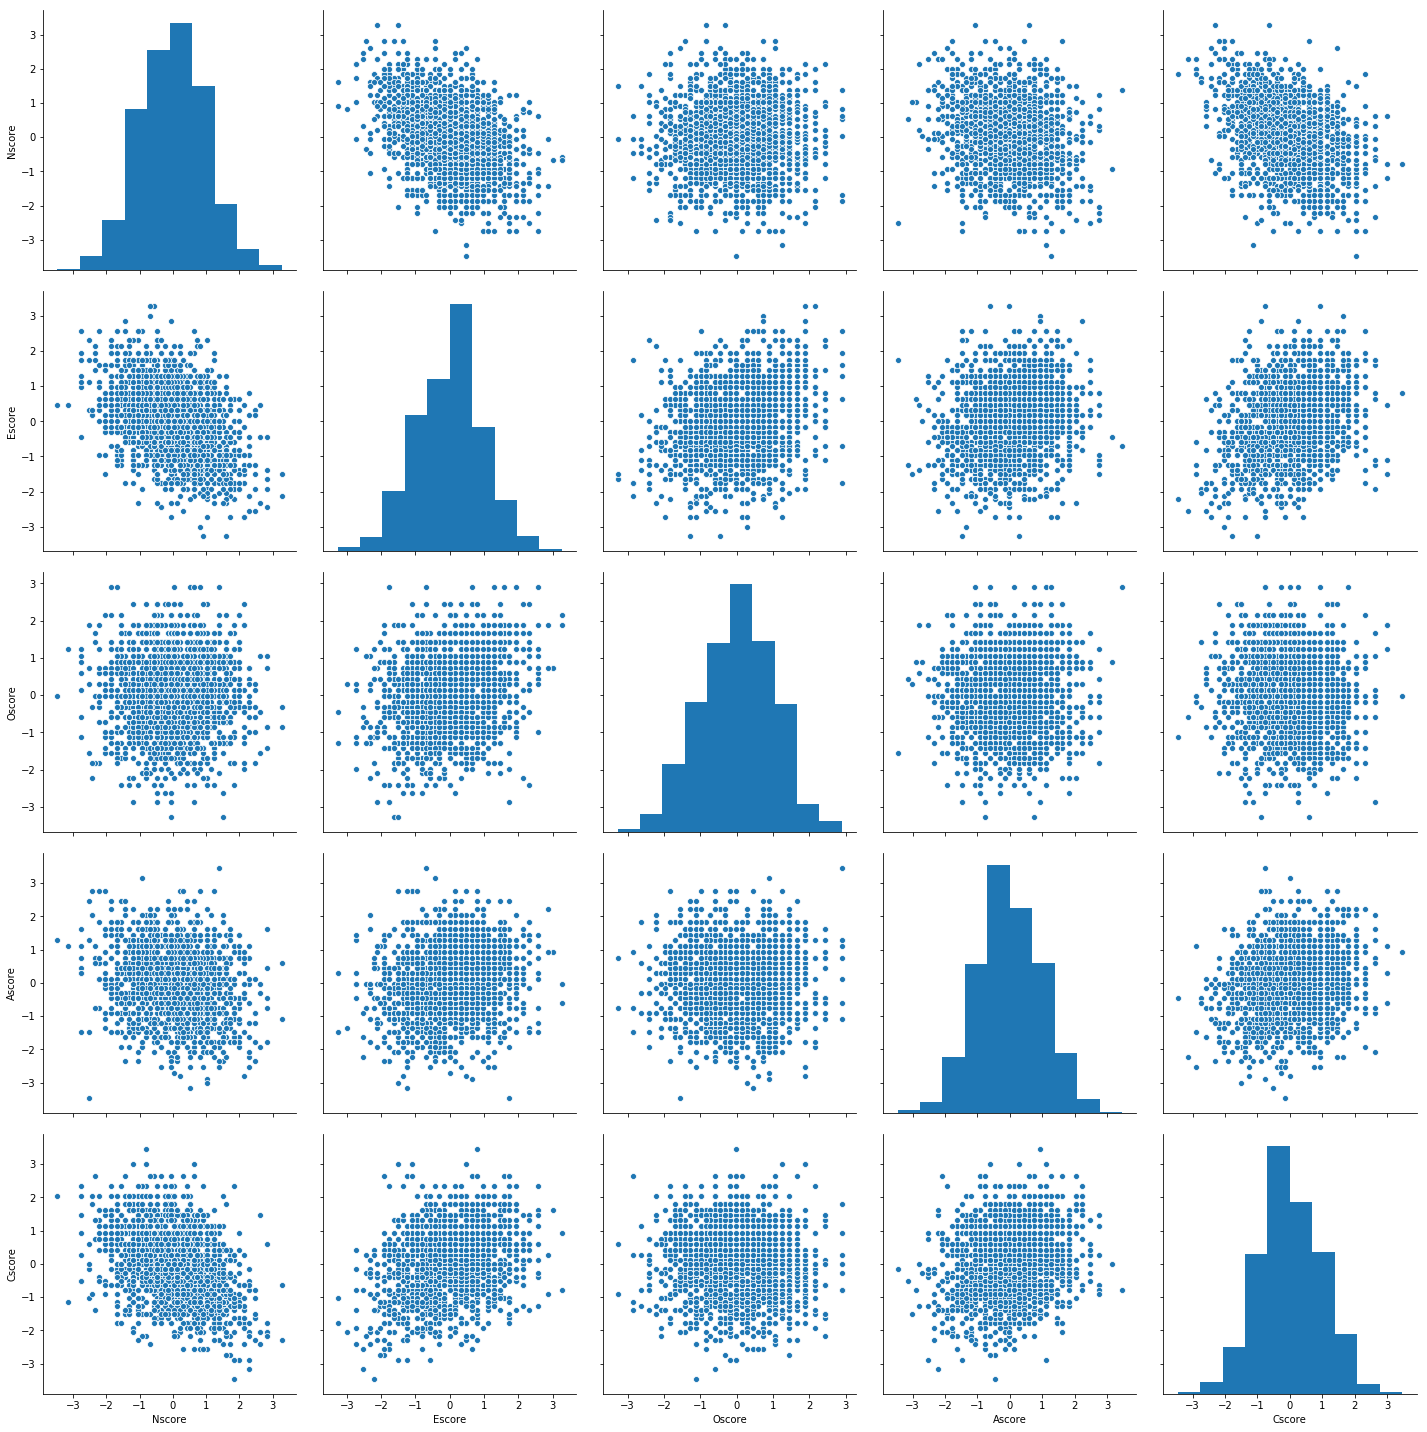

In [39]:
# Pairplot of numerical features
sns.pairplot(df, height = 4, vars=[
    'Nscore', 'Escore', 'Oscore', 
    'Ascore', 'Cscore'], );

In [38]:
# Value counts for the categorical variables
col_list = ['Age', 'Gender', 'Education', 'Country', 'Education', 'Ethnicity']
for feature in col_list:
    print("Counts per response:\n", {
            n: v for n, v in zip(df.loc[:,feature].value_counts().index, df.loc[:, feature].value_counts())
        });

Counts per response:
 {'18-24': 638, '25-34': 481, '35-44': 356, '45-54': 294, '55-64': 93, '65-100': 18}
Counts per response:
 {'Male': 940, 'Female': 940}
Counts per response:
 {'Some college or university': 503, 'University degree': 480, 'Masters degree': 283, 'Professional diploma/certificate': 270, 'Left school at age 18': 99, 'Left school at age 16': 99, 'Doctorate degree': 89, 'Left school at age 17': 29, 'Left school before age 16': 28}
Counts per response:
 {'UK': 1044, 'USA': 553, 'Other': 118, 'Canada': 87, 'Australia': 53, 'Republic of Ireland': 20, 'New Zealand': 5}
Counts per response:
 {'Some college or university': 503, 'University degree': 480, 'Masters degree': 283, 'Professional diploma/certificate': 270, 'Left school at age 18': 99, 'Left school at age 16': 99, 'Doctorate degree': 89, 'Left school at age 17': 29, 'Left school before age 16': 28}
Counts per response:
 {'White': 1718, 'Other': 62, 'Black': 33, 'Asian': 25, 'Mixed White/Asian': 20, 'Mixed Black/White':

In [74]:
print("Number of null values in each column:\n", df.isnull().sum(axis=0))

Number of null values in each column:
 ID                0
Age               0
Gender            0
Education         0
Country           0
Ethnicity         0
Nscore            0
Escore            0
Oscore            0
Ascore            0
Cscore            0
ImpulsiveScore    0
SS                0
Cannabis          0
Lower_Age         0
Upper_Age         0
dtype: int64


- These numerical features are normally distributed, and it also doesn't look like there's any that are extremely correlated

In [40]:
print("Shape of Cannabis data:", df.shape)

print("\nProportion each response:\n", {
    n: v for n, v in zip(df[drug].value_counts().index, df[drug].value_counts() / len(df))
})

Shape of Cannabis data: (1880, 16)

Proportion each response:
 {1: 0.6388297872340426, 0: 0.36117021276595745}


### Outline 
1. Import data
2. Prepare data for machine learning
3. Selecting target variable for classification
4. Explore data

**5. Training classification models**
6. Selecting a model
7. Generating predictions on test data

Now, we're ready to split the data into train and test sets for machine learning

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, df[drug], random_state= 42)

### Thinking about metrics and hyperparameters

Both preprocessing (one-hot encoding the categorical features, scaling the numerical ones) and hyperparameter adjustment can be included in a GridSearch object from sklearn.

By what metric should we use to select hyperparameters?

Because 64% of responses are in class 1, there would be a baseline accuracy of 0.64 if we predicted all responses to be class 1. 

Because it's slightly unbalance,
### Area Under the ROC curve may be a better evaluation metric than accuracy

Area under the ROC curve shows the probability that a value of the positive class will have a higher score than one of the negative class according to the decision function of the model. 

So I wrote a wrapper for a GridSearchCV object that 
- searches for the best parameters for a classifier
- reports a number of metrics for the classifier
- refits on a metric of choice
- produces a heatmap for cross validation results so we can visualize if we are searching the best hyperparameter space

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, average_precision_score,precision_score, roc_auc_score, accuracy_score

In [ ]:
def grid_search_wrapper(X_train, y_train, pipe, param_grid, refit_score):

In [50]:
    # Scores to report in the results
    scorers = {
        'roc_auc' : make_scorer(roc_auc_score),
        'precision_score' : make_scorer(precision_score),
        'accuracy' : make_scorer(accuracy_score)
    }

In [ ]:
    # Create a GridSearchCV instance optimized for refit_score 
    grid_search = GridSearchCV(pipe, param_grid, scoring=scorers, refit=refit_score, cv=5, return_train_score=True, n_jobs=-1)

    # Fit on training data
    grid_search.fit(X_train,y_train)

    # Store results of each cross val of the best kernel
    results = pd.DataFrame(grid_search.cv_results_)

In [ ]:
    #Print best params for the chosen score and the best cross-val score
    print(
        "Parmaeters when refit for {}".format(refit_score), 
        "\n {}".format(grid_search.best_params_), 
        "\nBest cross-val roc_auc score: {}".format(np.max(results.mean_test_roc_auc)),
        "\nBest cross-val accuracy score: {:.2f}".format(np.max(results.mean_test_accuracy)))

In [ ]:
    # Store the name of the score to plot on a heat map
    plot_score = 'mean_test_' + str(refit_score)

    # Store average cross-val score of each combo of parameters in an array the size of the parameter grid space
    scores = np.array(results[plot_score]).reshape(dim[0],dim[1])

    # Plot the score of each combo of parameters on a heatmap
    heatmap=sns.heatmap(scores, annot=True)
    plt.title('Cross-val test scores for ' + str(refit_score))
    plt.xlabel(params[1])
    plt.ylabel(params[0])
    plt.xticks(np.arange(dim[1]), results[subset_results[-1]].unique())
    plt.yticks(np.arange(dim[0]), results[subset_results[-2]].unique())
    plt.show()

In [74]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, average_precision_score,precision_score, roc_auc_score, accuracy_score


# Wrapper to fit GridSearchCV optimized with different scores:
def grid_search_wrapper(X_train, y_train, pipe, param_grid, refit_score):
    """
    Fits a GridSearchCV classifier that optimizes with refit_score and reports ROC AUC, precision score, and accuracy
    
    Arguments: 
    X_train = training features
    y_train training target
    pipe = a pipline object that include preprocessing steps and chosen classifier
    param_grid = a dict or list of dicts with keys as strings of the 
    parameter names and values are a list of possible values for the parameter
    refit_score = string naming the score to refit by

    Returns: tuple of GridSearchCV (for using for predictions) and results pandas DataFrame for evaluating the model
    """
    # Scores to report in the results
    scorers = {
        'roc_auc' : make_scorer(roc_auc_score),
        'precision_score' : make_scorer(precision_score),
        'accuracy' : make_scorer(accuracy_score)
    }

    # Create a GridSearchCV instance optimized for refit_score 
    grid_search = GridSearchCV(pipe, param_grid, scoring=scorers, refit=refit_score, cv=5, return_train_score=True, n_jobs=-1)

    # Fit on training data
    grid_search.fit(X_train,y_train)

    # Store results of each cross val of the best kernel
    results = pd.DataFrame(grid_search.cv_results_)

    # Make a list of the parameters to extract from results
    subset_results=['mean_test_precision_score', 'mean_test_roc_auc', 'mean_test_accuracy']
    
    # Initialize list of params and list of parameter dimensions for graphing
    params = []
    dim = []

    # SVC has a list parameter grid (two kernels)
    # extract SVC best kernel if the classifier used is SVC
    if 'svc__kernel' in grid_search.best_params_:
        best_kernel = grid_search.best_params_['svc__kernel']
    
    # add params to subset_results. If the classifier is SVC, only add the params for the best kernel
    if type(param_grid) == list:
        for grid in param_grid:
            if grid['svc__kernel']==[best_kernel]:
                for param in grid.keys():
                    dim.append(len(grid[param]))

                    # Save param for graphing later
                    if param not in params:
                        params.append(param)
                dim = dim[1:]
            for param in grid.keys():
                # Save param for graphing later
                if param not in params:
                    params.append(param)
            params=params[1:]
            # Add the param to the list of column names in results
            param_str='param_'+str(param)
            if param_str not in subset_results:
                subset_results.append(param_str)
        # Selected results
        results= results[results.param_svc__kernel==best_kernel].loc[:,subset_results].round(3).reindex()  
    else:
        for param in param_grid.keys():
            # Save param for graphing later
            params.append(param)
            # Save dimensions of param for graphing
            dim.append(len(param_grid[param]))
            param_str='param_'+str(param)
            if param_str not in subset_results:
                    subset_results.append(param_str)
        # Selected results
        results = results.loc[:,subset_results].round(3).reindex()  

    #Print best params for the chosen score and the best cross-val score
    print(
        "Parmaeters when refit for {}".format(refit_score), 
        "\n {}".format(grid_search.best_params_), 
        "\nBest cross-val roc_auc score: {}".format(np.max(results.mean_test_roc_auc)),
        "\nBest cross-val accuracy score: {:.2f}".format(np.max(results.mean_test_accuracy)))
    
    # Store the name of the score to plot on a heat map
    plot_score = 'mean_test_' + str(refit_score)

    # Store average cross-val score of each combo of parameters in an array the size of the parameter grid space
    scores = np.array(results[plot_score]).reshape(dim[0],dim[1])

    # Plot the score of each combo of parameters on a heatmap
    plt.figure(figsize=(10,6))
    sns.heatmap(scores, annot=True)
    plt.title('Cross-val test scores for ' + str(refit_score))
    plt.xlabel(params[1])
    plt.ylabel(params[0])
    plt.xticks(np.arange(dim[1]), results[subset_results[-1]].unique())
    plt.yticks(np.arange(dim[0]), results[subset_results[-2]].unique())
    plt.show()

    # Return both the grid search object and the results DataFrame
    returns = (grid_search, results)

    return returns

### Outline 
1. Import data
2. Prepare data for machine learning
3. Selecting target variable for classification
4. Explore data
5. Training classification models

**6. Selecting a model**
7. Generating predictions on test data

### Logistic regression

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import numpy as np

In [76]:
# First, we make a column transformer to scale the numerical features, and one-hot encode the categorical ones
ct = ColumnTransformer([
    ("num", StandardScaler(), ['Upper_Age', 'Lower_Age']), 
     ("cat", OneHotEncoder(handle_unknown = 'ignore', sparse=False), ['Gender', 'Education', 'Country', 'Ethnicity'])], 
     remainder='passthrough')

In [83]:
# Next, make a pipeline with the column transformer and the logistic regression instance
pipe = Pipeline([
    ("preparation", ct),
    ("logreg", LogisticRegression(solver='liblinear'))
])

In [84]:
# Now, we make a parameter grid for the grid search to search over
# l1 and l2 are types of regularization; they restrict the model and prevent it from overfitting by restricting the coefficients to be near zero. 
# l1 also forces some to be exactly 0 so that they can be ignorned entirely
param_grid = {
    'logreg__C': [0.001, 0.01, 1, 100],
    'logreg__penalty': ["l1", "l2"]
}
print("parameter grid:\n{}".format(param_grid))

parameter grid:
{'logreg__C': [0.001, 0.01, 1, 100], 'logreg__penalty': ['l1', 'l2']}


Parmaeters when refit for roc_auc 
 {'logreg__C': 0.01, 'logreg__penalty': 'l2'} 
Best cross-val roc_auc score: 0.733 
Best cross-val accuracy score: 0.77


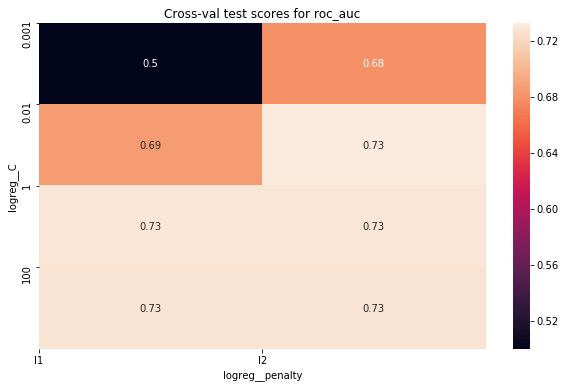

In [85]:
# Run the grid search, refitting with the ROC AUC metric
grid_search, logreg_results = grid_search_wrapper(X_train, y_train, pipe=pipe, param_grid=param_grid, refit_score='roc_auc');

# Assign the full pipeline for the estimator selected by the grid search to it's own object
logreg_pipe = grid_search.best_estimator_  

An ROC-AUC score of 0.73 is ok, but I wanted to see if another algorithm could do better.

### Next, we'll look at SVC (support vector classifier)

In [43]:
from sklearn.svm import SVC

In [87]:
# We can use the same ColumnTransformer instance as was used for Logistic regression
# We add the SVC to the pipeline

pipe = Pipeline([
    ("preparation", ct),
    ("svc", SVC())
])

Parmaeters when refit for roc_auc 
 {'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'} 
Best cross-val roc_auc score: 0.753 
Best cross-val accuracy score: 0.77


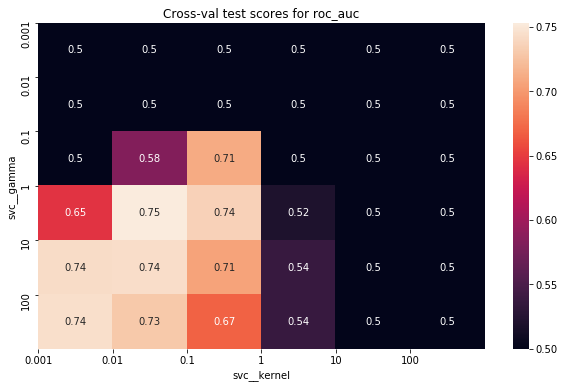

In [88]:
# This parameter grid is a list of dicts instead of a dict
param_grid = [
    {'svc__kernel': ['rbf'], 'svc__C': [0.001, 0.01, 0.1, 1, 10, 100], 'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, 
    {'svc__kernel': ['linear'], 'svc__C': [0.001, 0.01, 0.1, 1, 10, 100]}]

# Run the grid search
grid_search, svc_results = grid_search_wrapper(X_train, y_train, pipe, param_grid, refit_score='roc_auc')

In [89]:
param_grid = [
    {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10, 100, 1000, 10000], 'svc__gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}, 
    {'svc__kernel': ['linear'], 'svc__C': [0.001, 0.01, 0.1, 1, 10, 100]}]
print("parameter grid:\n{}".format(param_grid))

parameter grid:
[{'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10, 100, 1000, 10000], 'svc__gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1]}, {'svc__kernel': ['linear'], 'svc__C': [0.001, 0.01, 0.1, 1, 10, 100]}]


Parmaeters when refit for roc_auc 
 {'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'} 
Best cross-val roc_auc score: 0.753 
Best cross-val accuracy score: 0.77


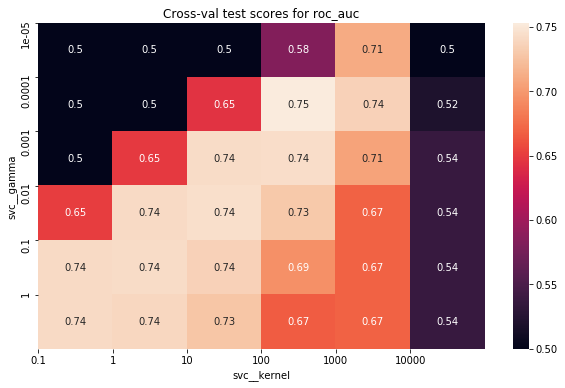

In [90]:
grid_search, svc_results = grid_search_wrapper(X_train, y_train, pipe, param_grid, refit_score='roc_auc')
svc_pipe = grid_search.best_estimator_

### Last, Random Forest classifier
RF is the average of a number of decision tree classifiers with some randomness injected into the tree-building process.

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [91]:
# For RF, we don't need to scale the numerical features, so we'll use a different column transformer
ct = ColumnTransformer([
     ("cat", OneHotEncoder(handle_unknown = 'ignore', sparse=False), ['Gender', 'Education', 'Country', 'Ethnicity'])], 
     remainder='passthrough')

pipe = Pipeline([
    ("preparation", ct),
    ("rf", RandomForestClassifier(n_estimators=200, random_state=2))
])

In [92]:
param_grid = {
    'rf__max_depth': [5, 15, 25, 35, 45],
    'rf__max_features': [4, 7, 10]
}
print("parameter grid:\n{}".format(param_grid))

parameter grid:
{'rf__max_depth': [5, 15, 25, 35, 45], 'rf__max_features': [4, 7, 10]}


Parmaeters when refit for roc_auc 
 {'rf__max_depth': 35, 'rf__max_features': 7} 
Best cross-val roc_auc score: 0.742 
Best cross-val accuracy score: 0.77


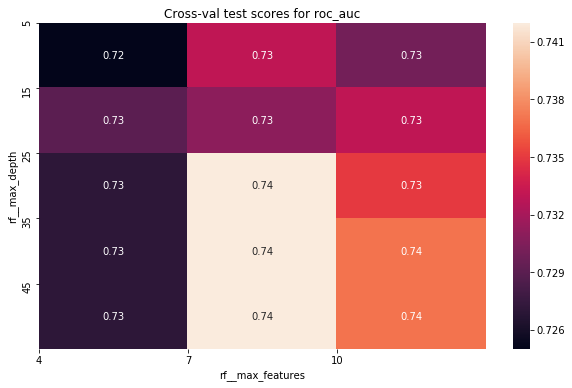

In [93]:
grid_search, rf_results = grid_search_wrapper(X_train, y_train, pipe=pipe, param_grid=param_grid, refit_score='roc_auc')
rf_pipe = grid_search.best_estimator_

The best CV score was 0.74, which isn't better than SVC CV score of 0.75. So, it looks like SVC is the best model.

In [94]:
print(svc_pipe)

Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', StandardScaler(copy=True, with_mean=True, with_std=True), ['Upper_Age', 'Lower_Age']), ('cat', OneHotEncoder(categorical_features=Non...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


### Another way to determine the best model is to do a grid search between the models and parameters together. 
This is demonstrated below:

In [45]:
ct = ColumnTransformer([
    ("num", StandardScaler(), ['Upper_Age', 'Lower_Age']), 
     ("cat", OneHotEncoder(handle_unknown = 'ignore', sparse=False), ['Gender', 'Education', 'Country', 'Ethnicity'])], 
     remainder='passthrough')

# Initialize pipe with column transformer and Log Reg
pipe = Pipeline([
    ("preparation", ct),
    ("classifier", LogisticRegression())
])

In [46]:
# Param grid with all possibilities for all models
param_grid = [
    {'classifier': [LogisticRegression(solver='liblinear')], 
    'classifier__C': [0.001, 0.01, 1, 100],
    'classifier__penalty': ["l1", "l2"]},
    {'classifier': [LogisticRegression(solver='lbfgs', penalty="l2", max_iter=500)], 
    'classifier__C': [0.001, 0.01, 1, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=200, random_state=2)],
    'classifier__max_depth': [15, 25, 35],
    'classifier__max_features': [4, 7, 10]},
    {'classifier': [SVC()],
    'classifier__C': [0.1, 1, 10, 100, 1000, 10000], 
    'classifier__gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}
]

In [47]:
# For this grid search between all classifiers, I decided to refit on ROC AUC

clf_grid = GridSearchCV(pipe, param_grid, cv=5, scoring=make_scorer(roc_auc_score))
clf_grid.fit(X_train, y_train)

print("Best classifier and params: \n{}\n".format(clf_grid.best_params_))
print("Best cross-val score: {:.2f}".format(clf_grid.best_score_))

Best classifier and params: 
{'classifier': SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 1, 'classifier__gamma': 0.01}

Best cross-val score: 0.75


### This grid search also came up with the same conclusion: SVC is the best estimator, with the above params

### Outline 
1. Import data
2. Prepare data for machine learning
3. Selecting target variable for classification
4. Explore data
5. Training classification models
6. Selecting a model

**7. Generating predictions on test data**

In [48]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report

Test set roc-auc for SVC: 0.81
Test set accuracy score for SVC: 0.76


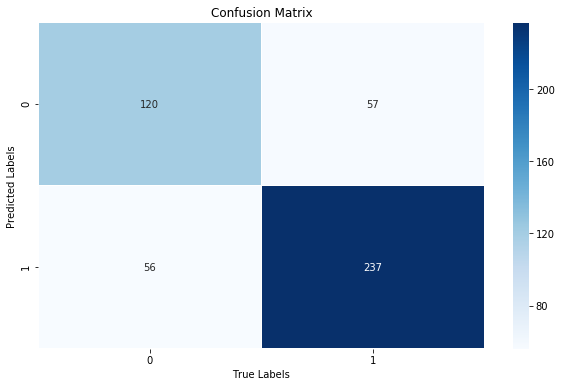

In [69]:
print("Test set roc-auc for SVC: {:.2f}".format(roc_auc_score(y_test, clf_grid.decision_function(X_test))))
print("Test set accuracy score for SVC: {:.2f}".format(accuracy_score(y_test, clf_grid.predict(X_test))))
cm=confusion_matrix(y_test, clf_grid.predict(X_test))
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, linewidth=0.5, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels');

## Inspecting the decision function

One aspect of looking at these evaluation metrics is that the model uses the default thresholds for the decision function, which is 0 (positive values are classified in the positive class). 

The model with the best ROC AUC may still not perform well if the threshold is in a suboptimal place. 

Because this model is still not getting an impressively high performance, I will take a look at the ROC curve to see if the threshold of the decision function is in the optimal place (i.e. high TPR and high FPR) 

#### We can plot the false positive rate by the true positive rate for every threshold value in the decision curve

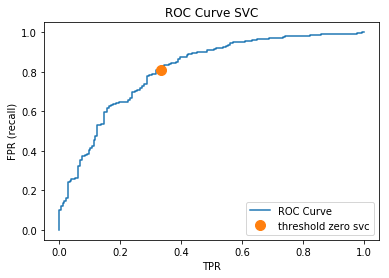

In [112]:
from sklearn.metrics import roc_curve

# Extract false positive rate and true positive rate
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, svc_pipe.decision_function(X_test))

# Extract the threshold by getting the value in the decision function that is closest to 0 (default is 0)
thresh_svc = np.argmin(np.abs(thresholds_svc))

def plot_roc():
    # Plot FPR and TPR
    plt.plot(fpr_svc, tpr_svc, label="ROC Curve")
    plt.ylabel('FPR (recall)')
    plt.xlabel('TPR')

    # Plot threshold
    plt.plot(fpr_svc[thresh_svc], tpr_svc[thresh_svc], 'o', markersize = 10, label = "threshold zero svc")
    plt.legend(loc=4)
    plt.title("ROC Curve SVC")
    plt.show()
plot_roc()

#### Looks like the default threshold for the decision function is in a pretty good spot, so this is probably the optimal model

## Feature importances

Although the SVC was the highest performing model, I wanted to extract feature importances from the Random Forest model in order to get an idea of which features were most predictive in that context.

#### We can visualize the feature importances from the Random Forest model

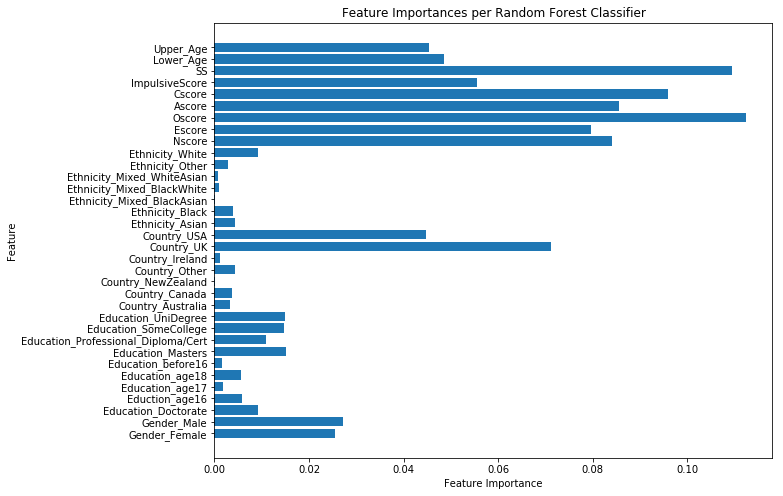

In [106]:
# Isolate the rf model from the pipeline 
rf = rf_pipe.named_steps['rf']

# These are the column names from the numpy array producted from the column transformer
ct_index = [
    'Gender_Female', 'Gender_Male', 'Education_Doctorate', 
    'Eduction_age16', 'Education_age17', 'Education_age18', 
    'Education_before16', 'Education_Masters', 'Education_Professional_Diploma/Cert', 
    'Education_SomeCollege', 'Education_UniDegree', 'Country_Australia', 
    'Country_Canada', 'Country_NewZealand', 'Country_Other', 'Country_Ireland', 
    'Country_UK', 'Country_USA', 'Ethnicity_Asian', 'Ethnicity_Black', 'Ethnicity_Mixed_BlackAsian',
    'Ethnicity_Mixed_BlackWhite', 'Ethnicity_Mixed_WhiteAsian', 'Ethnicity_Other', 
    'Ethnicity_White', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'ImpulsiveScore', 'SS',
    'Lower_Age', 'Upper_Age']

# Create a data frame of feature importances for each feature in the transformed dataset
feature_importances = pd.DataFrame(rf.feature_importances_, index=ct_index, columns=['importance']).sort_values('importance', ascending=False)

# Plot feature importnaces 
def plot_rf_feature_importance():
    """
    A function to plot feature importances as a horizontal barplot
    """
    plt.figure(figsize=(10,8))
    n_features = len(ct_index)
    plt.barh(np.arange(n_features), rf.feature_importances_, align='center')
    plt.yticks(np.arange(len(ct_index)), ct_index, size= 10)
    plt.ylabel("Feature")
    plt.xlabel("Feature Importance")
    plt.title("Feature Importances per Random Forest Classifier")
    plt.show()

plot_rf_feature_importance()

It's interesting that all of the most important features are the personality measures and not the demographic measures. I think it's interesting that this connects these abstract measures to a concrete behavior.

## The end